In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d


NameError: name 'points' is not defined

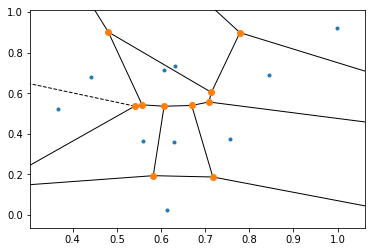

In [6]:
points = np.random.uniform(0,1,size=(10,2))
vor = Voronoi(points, incremental=True)
voronoi_plot_2d(vor)
plt.show()

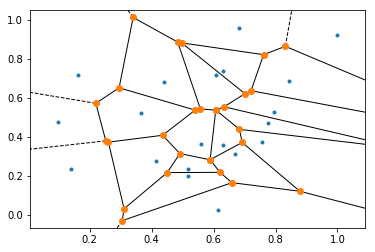

In [8]:
points = np.concatenate([points,np.random.uniform(0,1,size=(10,2))])
vor = Voronoi(points, incremental=True)
voronoi_plot_2d(vor)
plt.show()

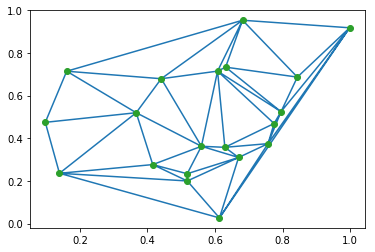

In [9]:
from scipy.spatial import Delaunay
tri = Delaunay(points, incremental=True)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0],points[:,1],'o')
plt.show()

#### The points in the Voronoi bins are the nodes of the Delaunay bins. Every point is connected to an amount of points equal to the amount of sides of the bin.

# 2. Barnes-Hut algorithm

In [10]:
import os

In [16]:
fname = 'lowres512.hdf5'
fdir = f'http://virgodb.cosma.dur.ac.uk/swift-webstorage/ICs/IsolatedGalaxies/{fname}'
if not os.path.isfile(fname):
    os.system(f'wget {fdir}')
    

In [17]:
ls

lowres512.hdf5  tut13.ipynb


In [20]:
print ("Can inspect with hdfview and gadgetviewer")

Can inspect with hdfview and gadgetviewer


In [21]:
import h5py
f = h5py.File(fname, 'r')

# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])

Keys: KeysView(<HDF5 file "lowres512.hdf5" (mode r)>)


In [33]:
# Gas particles
pp = f['PartType0/Coordinates'][:]
# Star particles
pstar = f['PartType4/Coordinates'][:]

In [34]:
print (np.shape(pp),np.shape(pstar))

(391, 3) (1758, 3)


In [41]:
# x and y positions of gas particles
gaspos = pp[:,:2]

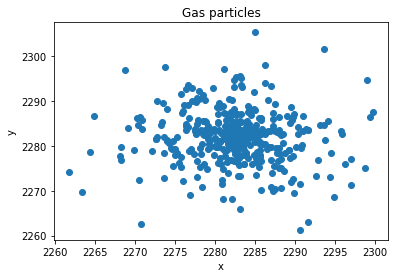

In [45]:
plt.scatter(gaspos[:,0],gaspos[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gas particles')
plt.show()

In [57]:
# Read from the HDFviewer
boxsize = np.array([4564.666879111894,4564.666879111894,4564.666879111894])
midpoint = boxsize/2
# print (midpoint)
midpoint = np.array(midpoint,dtype='int')
# print (midpoint)
size = np.array(boxsize-midpoint,dtype='int')
# print (size)

#### 2b) Construct a quad tree for xy positions

In [92]:
# Create 3 classes, Point, Node and QuadTree

# add points gradually, subdivide when threshold amount of points is met

class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
class Node():
    """ 
    Every node is a box in 2D.
    The box is defined from the lower left corner x0,y0 with a 
    certain width and height. 
    
    Every node contains points. Some nodes contain children
    """
    def __init__(self, x0,y0, width, height, points):
        # Origin of the node
        self.x0 = x0
        self.y0 = y0
        # width of the node
        self.width = width
        # height of the node
        self.height = height
        # Points inside the node
        self.points = points
        # Children of the node
        self.childs = []
    
class QuadTree():
    def __init__(self, positions, rnorigin, rnwidth, rnheight, thresh=1):
        # threshold for division
        self.thresh = thresh
        self.points = [Point(*pos) for pos in positions]
        self.rootnode = Node(*rnorigin,rnwidth,rnheight,self.points)
        
    def addpoint(self, x,y):
        self.points.append(Point(x,y))
        
    def get_points(self):
        return self.points
    
    def subdivide(self):
        recsubdivide(self.rootnode, self.thresh)
        
    def graph(self):
        fig = plt.figure(figsize=(12, 8))
        plt.title("Quadtree")
        ax = fig.add_subplot(111)
        c = find_children(self.rootnode)
        print ("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.height)
        print ("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            ax.add_patch(patches.Rectangle((n.x0, n.y0), n.width, n.height, fill=False))
        x = [point.x for point in self.points]
        y = [point.y for point in self.points]
        plt.plot(x, y, 'ro')
        plt.show()
        return
        

In [93]:
def findpoints(x, y, width, height, points):
    """
    Return the points in 'points' that are contained within the dimensions
    (x,x+width) (y,y+width)
    """
    containedpnts = []
    for point in points:
        if point.x >= x and point.x <= x+width and \
           point.y >= y and point.y <= y+height:
            containedpnts.append(point)
    return containedpnts


def recsubdivide(node, thresh):
    """
    Recursively subdivide a node until it contains <= thresh points
    """
    if len(node.points) <= thresh:
        return 
    
    # Subdivide both dimensions
    wnew = node.width/2
    hnew = node.height/2
    
    # Find points that are in lower left box of the subdivision
    pnts = findpoints(node.x0, node.y0, wnew, hnew, node.points)
    # Create the new node that has these points
    node1 = Node(node.x0, node.y0, wnew, hnew, pnts)
    # Also subdivide this node
    recsubdivide(node1, thresh)
    
    # Repeat for the other 3 nodes.
    pnts = findpoints(node.x0, node.y0+hnew, wnew, hnew, node.points)
    node2 = Node(node.x0, node.y0+hnew, wnew, hnew, pnts)
    recsubdivide(node2, thresh)
    
    pnts = findpoints(node.x0+wnew, node.y0, wnew, hnew, node.points)
    node3 = Node(node.x0+wnew, node.y0, wnew, hnew, pnts)
    recsubdivide(node3, thresh)
    
    pnts = findpoints(node.x0+wnew, node.y0+hnew, wnew, hnew, node.points)
    node4 = Node(node.x0+wnew, node.y0+hnew, wnew, hnew, pnts)
    recsubdivide(node4, thresh)
    
    # Keep track of the children
    node.children = [node1, node2, node3, node4]
    

Number of segments: 1
Minimum segment area: 2500.000 units


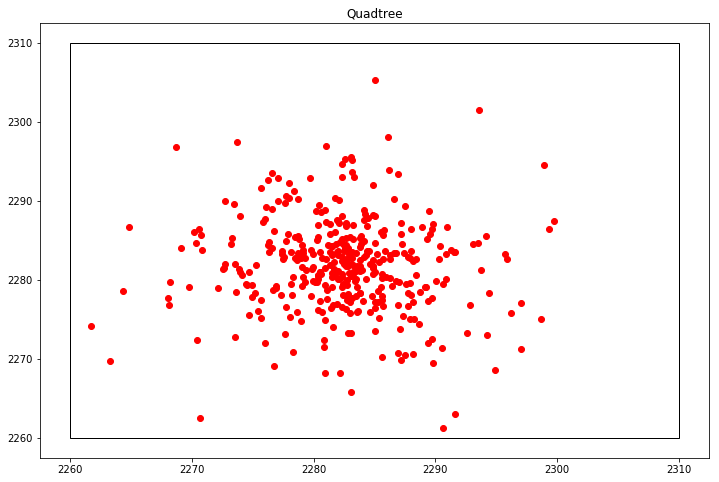

Number of segments: 1
Minimum segment area: 2500.000 units


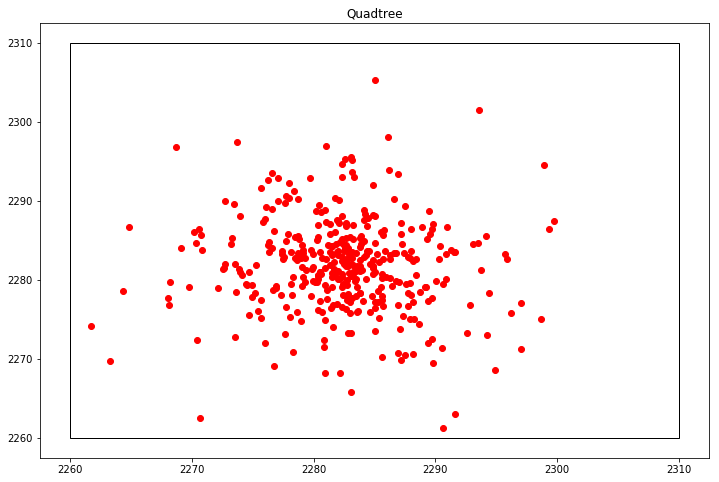

In [95]:
from matplotlib import patches

# For now just hardcode the dimensions
# root node origin
rnorigin = [2260,2260]
# root node width (of the box)
rnwidth = 2310-2260
# root node height (of the box)
rnheight = 2310-2260

# TODO REWRITE GRAPH AND FIND_CHILDREN

def find_children(node):
    if not node.childs:
        return [node]
    else:
        children = []
        for child in node.children:
            children += (find_children(child))
    return children

QT = QuadTree(gaspos, rnorigin, rnwidth, rnheight, thresh=1)
c = find_children(QT.rootnode)
print (c)
QT.graph()
plt.show()

QT.subdivide()
c = find_children(QT.rootnode)
print (c)
QT.graph()
plt.show()